# Survival Analysis of AML02 OS

## Where the data at?

In [1]:
aml02_cibersortx_results_path = '../Data/CIBERSORTx_Input/AML02/Results/CIBERSORTx_Job1_Results.csv'
aml02_clinical_data_path      = '../Data/Survival_Analysis/AML02/AML02_Clinical_Data_Mastersheet.xlsx'

cog_cibersortx_results_path   = '../Data/CIBERSORTx_Input/COG/Results/CIBERSORTx_Job1_Results.csv'
cog_clinical_data_path        = '../Data/Survival_Analysis/COG/COG_Raw_Clinical_Data.csv'
cog_calculated_lsc6_path      = '../Data/Survival_Analysis/COG/COG_Calculated_LSC_Scores_FM.xlsx'

## Which score is this?

In [2]:
score_name = 'AML02_CS_5'

## Libraries

In [3]:
# Import libraries for data manipulation
import pandas as pd

In [4]:
from FM_Functions.Cox_Lasso_Function import *
from FM_Functions.Clinical_Data_CleanUp import *

### St. Jude AML02 dataframe

In [5]:
# Read CIBERSORTx results file
cibersort_results = pd.read_csv(aml02_cibersortx_results_path, index_col=0).iloc[:,:-3]

# Standardize dataset (z-scoring)
x_aml02 = (cibersort_results-cibersort_results.mean())/cibersort_results.std()

# Read AML02 Clinical Outcome Data
df_aml02 = pd.read_excel(aml02_clinical_data_path, index_col=0)

# Adjust and Clean Clinical Data
df_aml02 = clean_aml02(df_aml02)

### COG AAML1031, 0531, 03P1 dataframe

In [6]:
# Read CIBERSORTx results file
cibersort_results2 = pd.read_csv(cog_cibersortx_results_path, index_col=0).iloc[:,:-3]

# Standardize dataset (z-scoring)
x_cog = (cibersort_results2-cibersort_results2.mean())/cibersort_results2.std()

# Read COG Clinical Outcome Data
df_cog = pd.read_csv(cog_clinical_data_path, index_col=0)

# Adjust and Clean Clinical Data
df_cog = clean_cog(df_cog)

Merge LSC6 score calculations to COG dataframe:

In [7]:
df_cog = df_cog.join(pd.read_excel(cog_calculated_lsc6_path, index_col=0)[['LSC17','LSC6','LSC PEDS NO FILTER']])

Calculate LSC6 Categorical score based on 0.6 quantile split of its discovery AML02 dataset:

In [8]:
df_cog['pLSC6_gb'] = pd.cut(df_cog['LSC6'],bins=[-np.inf, np.quantile(df_cog['LSC6'], 0.6), np.inf],
                                            labels=['Low', 'High'])

## Perform Survival Analysis

In [9]:
# raw_coefs = train_coxph_lasso(df=df_aml02,
#                                 event= 'os.evnt',
#                                 time= 'os.time',
#                                 train_x=x_aml02,
#                                 loops=1000)

# raw_coefs.to_csv('../Data/AML02_CiberScore_Raw_Coefs.csv')

Running Cox-Lasso through 1000 loops:


100%|██████████| 1000/1000 [08:37<00:00,  1.93it/s]

Cox-Lasso Trained Successfuly!
Selected alpha value: [0.10722858513588686]


In [10]:
raw_coefs_aml02 = pd.read_csv('../Data/AML02_CiberScore_Raw_Coefs.csv', index_col=0)

### Set Threshold

In [11]:
mean_coefs_aml02 = set_cutoff(coefs=raw_coefs_aml02,threshold=0.85)
mean_coefs_aml02                                    

NK cells activated            0.231761
Dendritic cells activated     0.181499
T cells CD4 memory resting    0.168456
Mast cells activated          0.098900
Mast cells resting           -0.219326
dtype: float64

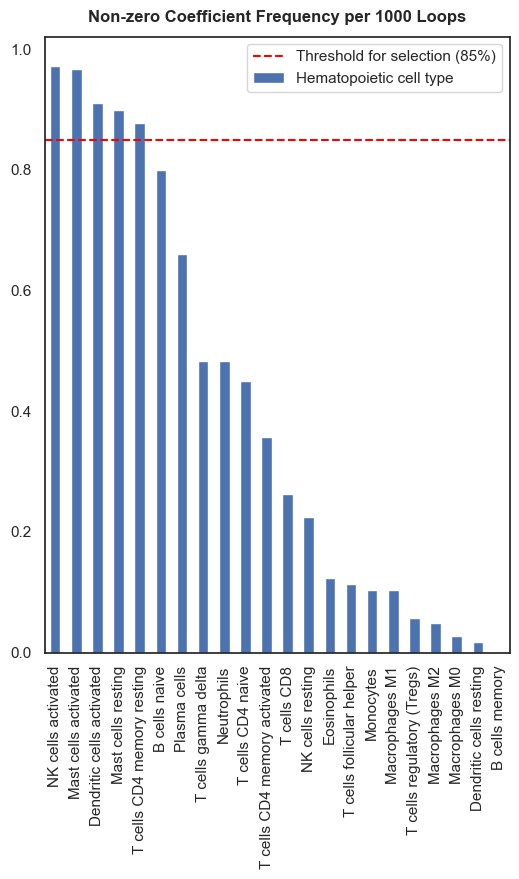

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='white')

_, ax = plt.subplots(figsize=(6,8))
raw_coefs_aml02['nonzero_freq'].plot.bar(ax=ax, legend=False, label='Hematopoietic cell type')
plt.title('Non-zero Coefficient Frequency per 1000 Loops', fontweight='bold', y=1.01)
plt.axhline(0.85, linestyle="--", color="red", label="Threshold for selection (85%)")
plt.legend()
plt.savefig('../Figures/Bar_Plots/AML02 - Non-zero Coefficient Frequency per 1000 Loops', bbox_inches='tight', dpi=300)

## Generate Model Results

### Discovery Dataset

In [13]:
df_aml02, aml02_cutoff = generate_coxph_score(coef_mean=mean_coefs_aml02,
                                        x=x_aml02,
                                        df=df_aml02,
                                        score_name=score_name,
                                        train_test="train",
                                        cutoff_train=0.75)

Continuous score cut at the value of 0.1073


### Validation Dataset

In [14]:
df_cog, _ = generate_coxph_score(coef_mean=mean_coefs_aml02,
                                            x=x_cog,
                                            df=df_cog,
                                            score_name=score_name,
                                            train_test=aml02_cutoff,
                                            cutoff_train=None)

Continuous score cut at the value of 0.1073


## Save files

In [15]:
df_aml02 = cibersort_results.join(df_aml02)

In [16]:
df_cog = cibersort_results2.join(df_cog)

In [17]:
df_aml02.to_csv('../Data/AML02_clinicaldata_ciberscore_FMcleaned.csv')
df_cog.to_csv('../Data/COG_clinicaldata_ciberscore_FMcleaned.csv')